<a href="https://colab.research.google.com/github/jpdosher/projetos_EDA/blob/main/Proj01_2022_dados_BBB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando biblliotecas iniciais

In [ ]:
!pip install googletrans==3.1.0a0
!pip install unidecode 
!pip install tweepy
!apt update
!apt install chromium-chromedriver
!pip install selenium
!pip install texthero
!pip install pytrends
!pip install python-louvain

     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 1.3 MB 16.5 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 65 kB 3.8 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=7d73520ab734b912408323cf19cdfcfa606ee4f2706d1c3b948a469224e913a0
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans
     |████████████████████████████████| 235 kB 8.9 MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_6

In [ ]:
#bibliotecas para uso geral
import re
import time
import string
import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

#para scraping e EDA
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import texthero as hero
from texthero import stopwords
import nltk

#para análise de redes
import networkx as nx
from community import community_louvain


#para API´s
from pytrends.request import TrendReq
import requests #para requests nas API´s e no Selenium
import tweepy #acesso e manipulação da API do twitter 

#para análise de sentimento
from textblob import TextBlob 
from googletrans import Translator
from unidecode import unidecode

#wordcloud e imagens
from wordcloud import WordCloud, STOPWORDS
import warnings
from PIL import Image

#Para mapa de calor
from geopy.geocoders import Nominatim
import folium
from folium import plugins
from geopy.geocoders import Nominatim

## Scraping do site gshow

### Com Selinium webdriver

In [ ]:
# set options to be headless, ..     (Solução para o erro de PATH)
##from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
wd = webdriver.Chrome(options=options)
wd.get("https://gshow.globo.com/realities/bbb/")
print(wd.title) #verificar se funcionou



BBB 22 | Últimas notícias, vídeos e mais do Big Brother Brasil | Gshow


In [ ]:
# Web scrapper for infinite scrolling page

SCROLL_PAUSE_TIME = 3

# Get scroll height
last_height = wd.execute_script("return document.body.scrollHeight")

#for i in range(8000): #para rodar em "teste"
while True:
    # Scroll down to bottom
    wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = wd.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

    #Localizar e clicar no botão "Veja mais"
    time.sleep(SCROLL_PAUSE_TIME + 1)
    button = wd.find_element_by_css_selector('.load-more > a:nth-child(1)')
    button.click()
    if button.click:
      print('Botão OK')


posts = wd.find_elements(By.CLASS_NAME,"post-text")

for block in posts:
    print(block.text)
    

In [ ]:
#Altura final da página, com as rolagens infinitas e clicks nos botões "Veja Mais"
new_height 

451527

### Scrapping com soup

- Neste momento já consegui "ler" a página em sua integra (realizando as rolagens da barra de rolagem). 

A próxima etapa é o scrapping propriamente dito:

1)interpretando o código HTML da página para localizar os pontos de interesse

2)iterando para copiar o texto desejável

3)exportando o resultado

In [ ]:
soup = BeautifulSoup(wd.page_source,'html5lib')
#page = BeautifulSoup(driver.page_source,'lxml')  

In [ ]:
soup.prettify()

'<html amp-version="2203041950000" class="has-not-regua tag-manager-publicidade-banner_slb_topo--visivel proximanova-bold has-search proximanova-light proximanova-semibold-limited-webfont i-amphtml-singledoc i-amphtml-standalone tag-manager-publicidade-banner_feed__0--visivel tag-manager-publicidade-banner_vitrine--visivel tag-manager-publicidade-banner_middle_feed__1--vazio tag-manager-publicidade-banner_feed__1--vazio tag-manager-publicidade-banner_middle_feed__2--vazio tag-manager-publicidade-banner_feed__2--visivel tag-manager-publicidade-banner_feed__3--vazio tag-manager-publicidade-banner_middle_feed__3--vazio tag-manager-publicidade-banner_middle_feed__4--vazio tag-manager-publicidade-banner_feed__4--vazio tag-manager-publicidade-banner_feed__5--vazio tag-manager-publicidade-banner_middle_feed__5--vazio tag-manager-publicidade-banner_middle_feed__6--vazio tag-manager-publicidade-banner_feed__6--vazio tag-manager-publicidade-banner_feed__7--vazio tag-manager-publicidade-banner_mi

### Procurando elementos desejados no "soup"

Divisão de interesse na página:

"< div class ="post-materia-text__title"></div>"


"< div class ="post-materia-text__description"></div>"

  //remover o espaço entre < e div...
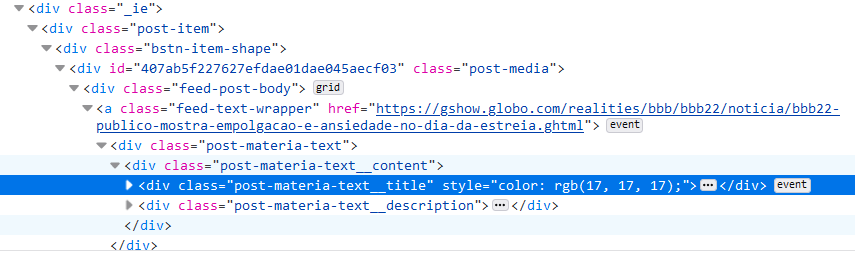
  
Obs: o que preciso é chegar neste DIV?



In [ ]:
#procurar por elemento de div class
dados = soup.find_all('div', class_="post-materia-text__title")   #aqui está pegando o text_description

In [ ]:
# checar comprimento de dados do elemento resultante(bs4.element.ResultSet)
len(dados)

1643

In [ ]:
#povoando a lista posts_list com os textos extraídos
posts_list = list()
for i in range(len(dados)):
  posts_list.append(dados[i].extract().text)
print(len(posts_list))
print(posts_list[0])

1643
Dinâmica da Semana no BBB 22: Paredão triplo terá contragolpe do indicado do Líder e parte da votação aberta


## EDA

Já tenho os 'posts' separados em uma lista, para esta próxima etapa irei explorá-los no intuito de tentar 'enxergar' algo nos dados.

In [ ]:
#listas de participantes
camarote = ['Arthur Aguiar','Pedro Scooby','Brunna Gonçalves','Paulo André','Jade Picon','Naiara Azevedo','Tiago Abravanel','Natália Deodato','Douglas Silva','Linn da Quebrada','Maria']
pipoca = ['Bárbara Heck','Eliezer','Lucas Bissoli','Laís Caldas','Luciano Estevan','Jessilane Alves','Rodrigo Mussi','Eslovênia','Vinicius','Gustavo Marsengo','Larissa Tomásia']
participantes = camarote + pipoca
participantes = sorted(participantes)
print(participantes)

['Arthur Aguiar', 'Brunna Gonçalves', 'Bárbara Heck', 'Douglas Silva', 'Eliezer', 'Eslovênia', 'Gustavo Marsengo', 'Jade Picon', 'Jessilane Alves', 'Larissa Tomásia', 'Laís Caldas', 'Linn da Quebrada', 'Lucas Bissoli', 'Luciano Estevan', 'Maria', 'Naiara Azevedo', 'Natália Deodato', 'Paulo André', 'Pedro Scooby', 'Rodrigo Mussi', 'Tiago Abravanel', 'Vinicius']


O fato da lista de participantes terem nomes e sobrenomes retorna mençoes inadequadas/repetidas. Para corrigir devo considerar apenas os "primeiros" nomes dos participantes.

In [ ]:
#split lista participantes
participantes_split = list()
for i in range(len(participantes)):
  if " " in participantes[i]:
    participantes_split.append(participantes[i][:(participantes[i].find(" "))])
  else:
    participantes_split.append(participantes[i])
print(participantes_split)
print(len(participantes_split))

['Arthur', 'Brunna', 'Bárbara', 'Douglas', 'Eliezer', 'Eslovênia', 'Gustavo', 'Jade', 'Jessilane', 'Larissa', 'Laís', 'Linn', 'Lucas', 'Luciano', 'Maria', 'Naiara', 'Natália', 'Paulo', 'Pedro', 'Rodrigo', 'Tiago', 'Vinicius']
22


### Análise dos textos

In [ ]:
#Para análise do texto:
  #Convertendo post_list em string
post_texto = str()
for i in posts_list:
  post_texto = post_texto + str(i) + "\n"
# print(post_texto)

In [ ]:
#contando quantidade de mençoes de cada participante
mencoes_list = list()
for i in range(len(participantes_split)):
  mencoes_list.append(post_texto.count(participantes_split[i]))


In [ ]:
#Ordendar do maior para o menor (com pandas)
dt_mencoes = pd.Series(mencoes_list,participantes_split)
dt_mencoes = dt_mencoes.sort_values(ascending = False)

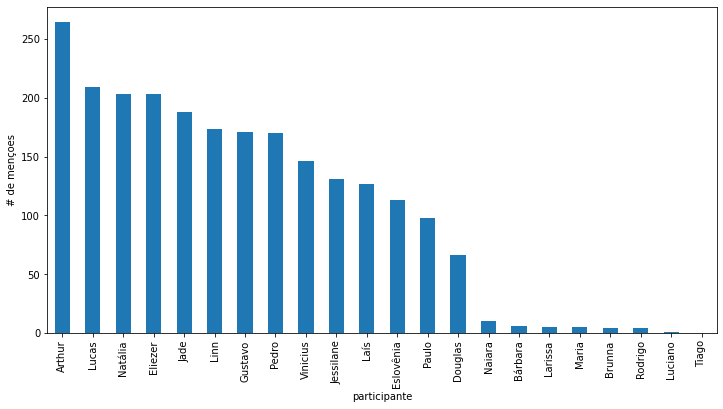

In [ ]:
#plotagem das menções
dt_mencoes.plot(kind ="bar", xlabel = "participante", ylabel ="# de mençoes", figsize = (12,6))

Analisando os textos

In [ ]:
#transformando o texto em um pd series
pd_texto = pd.Series(post_texto)

In [ ]:
#removendo pontuação e dígitos
pd_texto = hero.remove_punctuation(pd_texto)
pd_texto = hero.remove_digits(pd_texto)


In [ ]:
pd_texto

0    Dinâmica da Semana no BBB    Paredão triplo te...
dtype: object

### Nuvem de palavras

In [ ]:
#para remover as stopwords (texthero não tem suporte para o português)
nltk.download('stopwords')
stopwords_pt = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
default_stopwords = stopwords.DEFAULT
custom_stopwords = stopwords_pt
pd_semstop = hero.remove_stopwords(pd_texto, custom_stopwords)

In [ ]:
#top 10 palavras
top_words = hero.top_words(pd_semstop)
top_words.head(10)

BBB        1112
sobre       415
No          263
Arthur      262
Aguiar      241
Paredão     235
Líder       215
Lucas       209
Eliezer     203
Natália     203
dtype: int64

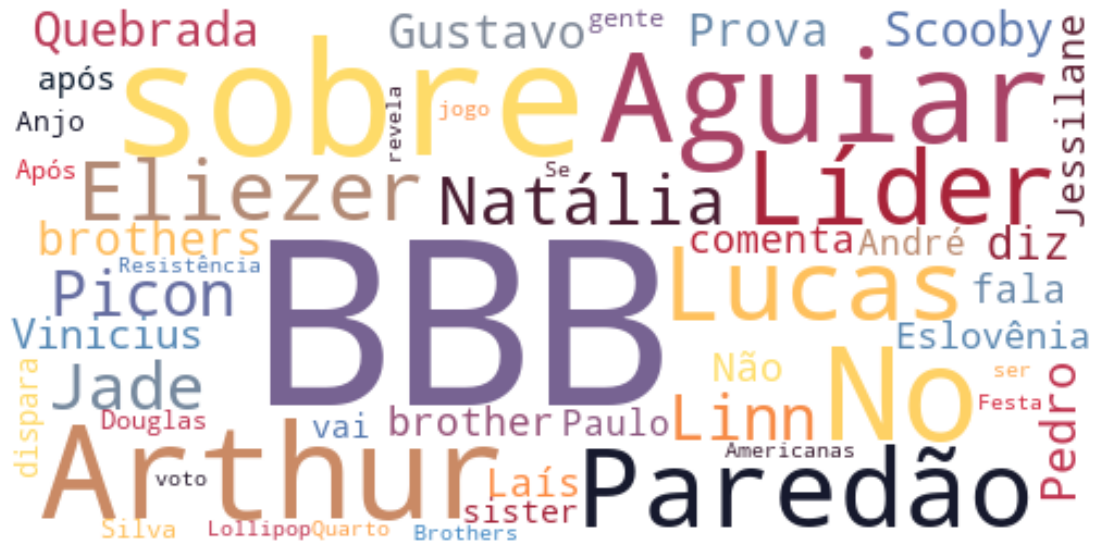

In [ ]:
#nuvem de palavras
hero.visualization.wordcloud(pd_semstop, max_words= 50, height=250, width=500, background_color='White')

## Análise de redes

In [ ]:
#gerar pares utilizando posts_list
pares = list()
for i in range(len(posts_list) ):
  for j in range(len(participantes_split)):
    for k in range(len(participantes_split)):
      if participantes_split[j] != participantes_split[k]:
        if participantes_split[j] in posts_list[i] and participantes_split[k] in posts_list[i]:
          pares.append([participantes_split[j],participantes_split[k]])

In [ ]:
print(pares)

[['Arthur', 'Lucas'], ['Lucas', 'Arthur'], ['Eslovênia', 'Lucas'], ['Lucas', 'Eslovênia'], ['Arthur', 'Pedro'], ['Pedro', 'Arthur'], ['Eslovênia', 'Lucas'], ['Eslovênia', 'Pedro'], ['Lucas', 'Eslovênia'], ['Lucas', 'Pedro'], ['Pedro', 'Eslovênia'], ['Pedro', 'Lucas'], ['Eliezer', 'Gustavo'], ['Gustavo', 'Eliezer'], ['Eslovênia', 'Lucas'], ['Lucas', 'Eslovênia'], ['Eliezer', 'Gustavo'], ['Gustavo', 'Eliezer'], ['Gustavo', 'Laís'], ['Laís', 'Gustavo'], ['Eslovênia', 'Gustavo'], ['Gustavo', 'Eslovênia'], ['Gustavo', 'Laís'], ['Laís', 'Gustavo'], ['Eslovênia', 'Lucas'], ['Lucas', 'Eslovênia'], ['Eliezer', 'Gustavo'], ['Gustavo', 'Eliezer'], ['Eliezer', 'Gustavo'], ['Gustavo', 'Eliezer'], ['Gustavo', 'Laís'], ['Laís', 'Gustavo'], ['Eliezer', 'Laís'], ['Laís', 'Eliezer'], ['Eliezer', 'Gustavo'], ['Gustavo', 'Eliezer'], ['Gustavo', 'Laís'], ['Laís', 'Gustavo'], ['Natália', 'Pedro'], ['Pedro', 'Natália'], ['Lucas', 'Pedro'], ['Pedro', 'Lucas'], ['Arthur', 'Laís'], ['Laís', 'Arthur'], ['Arthur'

### Grafos

In [ ]:
#criando o grafo e adicionando nós
G_bbb = nx.Graph()
G_bbb.add_edges_from(pares)


In [ ]:
#informações de rede
print(nx.info(G_bbb))

Graph with 19 nodes and 111 edges


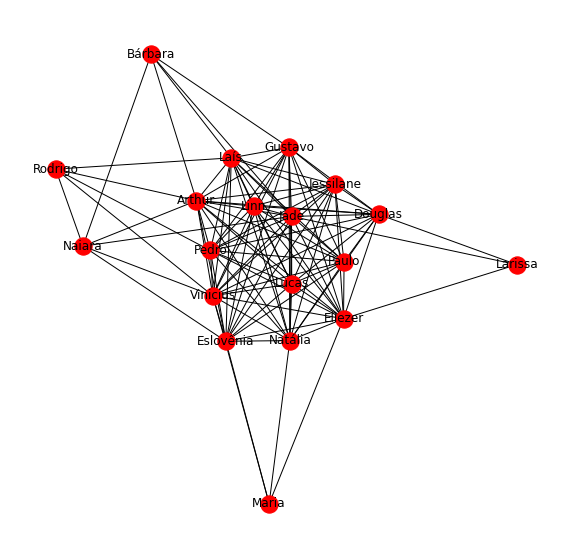

In [ ]:
#plotando os grafos
plt.figure(figsize=(10,10))
plt.axis("off")

# Manter a rede na mesma posição
np.random.seed(0)
# Criar o layout da nossa rede
position = nx.spring_layout(G_bbb)

# Desenhar a rede
nx.draw_networkx(G_bbb, pos=position, node_color='red', font_size=12);

No grafo os vértices centrais tem mais pontos de ligação(arestas) ligados a si.

### Grau de centralidade

In [ ]:
# Calcular o grau de centralidade
centralidade = nx.degree_centrality(G_bbb)
#Por ordem
for i in sorted(centralidade,key = centralidade.get, reverse=True):
  print(i,centralidade[i])

Arthur 0.8888888888888888
Jade 0.8888888888888888
Vinicius 0.8888888888888888
Eliezer 0.8333333333333333
Laís 0.8333333333333333
Eslovênia 0.7777777777777777
Pedro 0.7777777777777777
Gustavo 0.7777777777777777
Natália 0.7777777777777777
Lucas 0.7222222222222222
Linn 0.7222222222222222
Douglas 0.7222222222222222
Paulo 0.7222222222222222
Jessilane 0.7222222222222222
Naiara 0.3333333333333333
Rodrigo 0.2777777777777778
Bárbara 0.2777777777777778
Maria 0.2222222222222222
Larissa 0.16666666666666666


Para efeito de experimentação, digamos que queremos saber o menor "caminho" que liga dois participantes:

In [ ]:
# Usar o algoritmo de shortest path
nx.shortest_path(G_bbb, 'Linn', 'Pedro')

['Linn', 'Pedro']

### Detecção de comunidades

In [ ]:
# Computar os grupos
partitions = community_louvain.best_partition(G_bbb)

# Transformar os valores em lista
values = list(partitions.values())

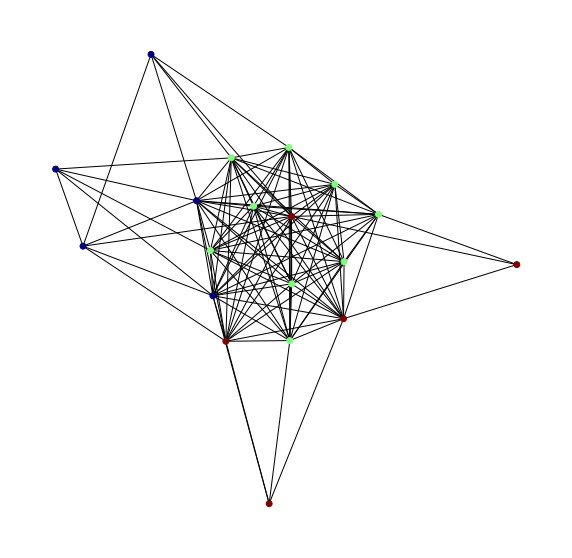

In [ ]:
plt.figure(figsize=(10,10))
plt.axis("off")

# Mostrar as diferentes comunidades identificadas separado por cor
nx.draw_networkx(G_bbb, pos=position, cmap=plt.get_cmap("jet"), 
                 node_color=values, node_size=35, with_labels = False)

In [ ]:
#quantidade de comunidades detectadas
len(list(set(values)))

3

## API´s

### API Google Trends

Usando a API do Google Trends e a biblioteca pytrend

In [ ]:
pytrend = TrendReq(hl="pt-BR")
kw_list = ['bbb 22','BBB22','bbb22']
hoje = datetime.date.today()
print(hoje)


2022-03-19


In [ ]:
#Payload
all_keywords = [
    'bbb 22 ',
    'BBB22',
    'bbb22'
    ]
cat = '0' #default
timeframes = [
    f'2022-01-17 {hoje}'
    ]
geo = 'BR'
gprop = '' #websearch
pytrend.build_payload(
    kw_list,
    cat,
    timeframes[0],
    geo,
    gprop
    )

In [ ]:
#Verificar tendências ao longo do tempo
keywords = []
def check_trends():
  pytrend.build_payload(
      kw_list,
      cat,
      timeframes[0],
      geo,
      gprop,
  )
data = pytrend.interest_over_time()
for keyword in all_keywords:
  keywords.append(keyword)
  check_trends()
  keywords.pop()


In [ ]:
mean = round(data.mean(),2)
mean

bbb 22       25.02
BBB22         5.53
bbb22         5.53
isPartial     0.02
dtype: float64

Aqui fica evidente que o termo "bbb 22" é o mais empregado 

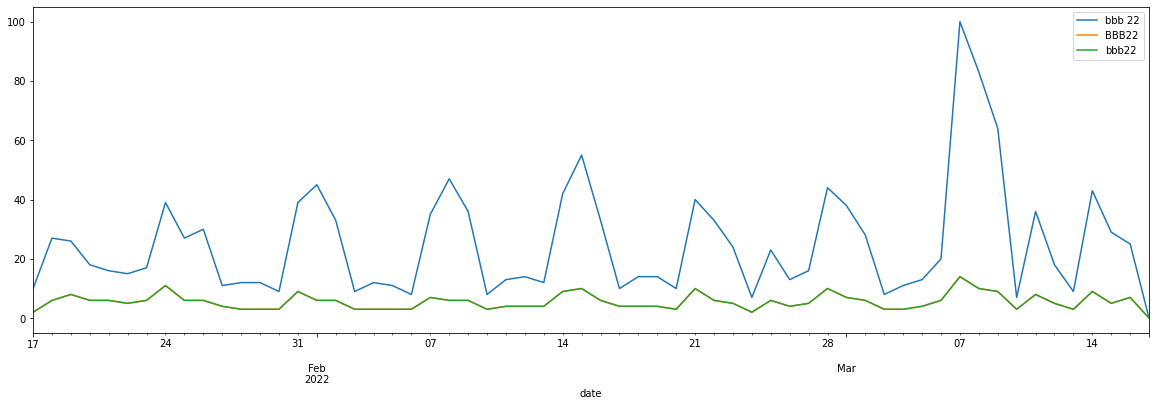

In [ ]:
data.plot(figsize = (20,6))
#pico em 7 de março

In [ ]:
#Sugestões de categorias
keywords = pytrend.suggestions(keyword ="bbb 22")
df_keyword = pd.DataFrame(keywords)
df_keyword.head(5)

mid                              title  \
0   /m/01vz0g4               The Notorious B.I.G.   
1     /m/03y53  International Bank Account Number   
2  /g/12345gtb            Berliner Bäder-Betriebe   
3  /g/1tf2xfr9              K-BID Online Auctions   
4    /m/01xbj3                       Robert Reich   

                                           type  
0                                       Artista  
1                                       Assunto  
2                                       Assunto  
3     Casa de leilões na Maple Plain, Minnesota  
4  Ex-secretário do Trabalho dos Estados Unidos

In [ ]:
#pesquisas relacionadas
df_rel_queries = pytrend.related_queries()
list(df_rel_queries)

['bbb 22', 'BBB22', 'bbb22']

In [ ]:
#interesse regional
interesse_regiao = pytrend.interest_by_region(resolution='COUNTRY')
interesse_regiao

bbb 22  BBB22  bbb22
geoName                                  
Acre                     72     14     14
Alagoas                  69     15     16
Amapá                    71     14     15
Amazonas                 72     14     14
Bahia                    72     14     14
Ceará                    74     13     13
Distrito Federal         73     13     14
Espírito Santo           72     14     14
Goiás                    78     11     11
Maranhão                 74     13     13
Mato Grosso              72     14     14
Mato Grosso do Sul       73     13     14
Minas Gerais             69     15     16
Paraná                   70     15     15
Paraíba                  73     13     14
Pará                     76     12     12
Pernambuco               76     12     12
Piauí                    70     15     15
Rio Grande do Norte      72     14     14
Rio Grande do Sul        70     15     15
Rio de Janeiro           68     16     16
Rondônia                 68     16     16
Roraima                  71     14     15
Santa Catarina           72     14     14
Sergipe                  68     16     16
São Paulo                68     16     16
Tocantins                70     15     15

Os valores são calculados em uma escala de 0 a 100, onde 100 é o local com mais popularidade como uma fração do total de pesquisas nesse local, um valor de 50 indica um local com metade da popularidade. Um valor de 0 indica um local onde não havia dados suficientes para este termo. Fonte → Google Trends..


### API Twitter

#### API request

Para requests na API do Twitter é necessário liberação do acesso pelo próprio Twitter, serão fornecidos:

    Consumer Key (API Key)
    Consumer Secret (API Secret)
    Access Token
    Access Token Secret


In [ ]:
#Keys autenticadores
auth = tweepy.OAuthHandler("CONSUMER_KEY", "CONSUMER_SECRET)
auth.set_access_token("ACCESS_TOKEN", "ACCESS_SECRET")
api = tweepy.API(auth,wait_on_rate_limit=True,retry_count=10, retry_delay=1, )



In [ ]:
query_search_words = "#bbb 22"+"-filter:retweets"+"-has" ##BBB22"+"-filter:retweets"+"-has",

In [ ]:
#iterando pelo tweepy.Cursor para povoas as listas
tweet_time = []
tweet_string = []
tweet_location = []

for tweet in tweepy.Cursor(api.search,q= query_search_words, lang="pt", retry_count=10,
                           retry_delay=1, wait_on_rate_limit=True, count=10000).items(10000):
        if (not tweet.retweeted) and ('RT @' not in tweet.text):
            if tweet.lang == "pt":
                # twitter_users.append(tweet.user.name)
                tweet_time.append(tweet.created_at)
                tweet_string.append(tweet.text)
                #print([tweet.created_at,tweet.text])
                tweet_location.append(tweet.user.location)

In [ ]:
#limpando os textos
for i in range(len(tweet_string)):
  tweet_string[i] = re.sub(r'RT+', '', tweet_string[i]) 
  tweet_string[i] = re.sub(r'@\S+', '', tweet_string[i])  
  tweet_string[i] = re.sub(r'http\S+', '', tweet_string[i]) 
  #tweet_string[i] = clean_text.replace("\n", " ")


In [ ]:
#criando dataframe com dados originais
tweets_df_pt = pd.DataFrame(list(zip(tweet_time,tweet_string,tweet_location)), columns = ['Data','Texto','Localização'])
tweets_df_pt = tweets_df_pt.drop_duplicates(subset = ['Texto']  ,keep = 'first')
tweets_df_pt

Data                                              Texto  \
0    2022-03-20 08:10:04  Pedro Scooby avalia formação do 9º Paredão do ...   
4    2022-03-20 07:45:04  Arthur Aguiar reflete sobre o convívio no BBB ...   
8    2022-03-20 07:35:03  Pedro Scooby especula com Lucas e Eslovênia: '...   
12   2022-03-20 07:00:03  Na cozinha do VIP do BBB 22, Lucas brinca após...   
16   2022-03-20 05:00:04  Gustavo improvisa canção de ninar no Castigo d...   
...                  ...                                                ...   
3001 2022-03-12 00:34:33  Quem sai neste suposto paredão? #Arthur #Arthu...   
3002 2022-03-12 00:17:21  Quem sai neste suposto paredão? #Arthur #Arthu...   
3003 2022-03-12 00:15:04  Prova do Líder de Resistência Americanas ating...   
3007 2022-03-12 00:07:10  Quem vence a prova do líder ?  PROVA DE RESIST...   
3008 2022-03-12 00:00:03  Linn da Quebrada e Natália tentam convencer Lu...   

        Localização  
0            Brasil  
4            Brasil  
8            Brasil  
12           Brasil  
16           Brasil  
...             ...  
3001                 
3002                 
3003         Brasil  
3007  Bahia, Brasil  
3008         Brasil  

[1045 rows x 3 columns]

In [ ]:
#traduzindo e salvando em uma lista separada
tweet_string_en = tweet_string
for i in range(len(tweet_string_en)):
  tweet_string_en[i] = (unidecode(tweet_string[i]))
  tweet_string_en[i] = (Translator().translate(tweet_string[i]))

#### Análise de sentimentos

In [ ]:
#contabilzando sentimentos em uma lista
tweets_sentiments_list_en = []
for tweet in tweet_string_en:
  polarity = TextBlob(tweet.text).sentiment.polarity
  if polarity > 0:
    tweets_sentiments_list_en.append('Positivo')
  elif polarity < 0:
    tweets_sentiments_list_en.append('Negativo')
  else:
    tweets_sentiments_list_en.append('Neutro')

In [ ]:
#separando apenas o texto do objeto Translate
tweet_tr = []
for tweet in range(len(tweet_string_en)):
  tweet_tr.append(tweet_string_en[tweet].text)
  

In [ ]:
#criando um dataframe no pandas
tweets_df = pd.DataFrame(list(zip(tweet_time,tweet_tr,tweet_location,tweets_sentiments_list_en)), columns = ['Date','Texto','Localização','Sentimento'])
tweets_df = tweets_df.drop_duplicates(subset = ['Texto']  ,keep = 'first')
#tweets_df

In [ ]:
tweets_df.Sentimento.value_counts()

Neutro      574
Positivo    292
Negativo    176
Name: Sentimento, dtype: int64

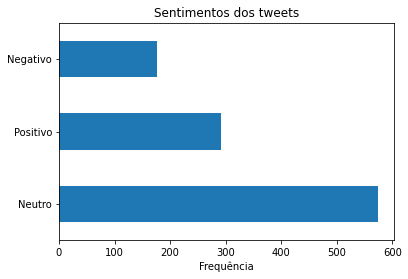

In [ ]:
plt.clf()
tweets_df['Sentimento'].value_counts().plot(kind = 'barh')
plt.title('Sentimentos dos tweets')
plt.xlabel('Frequência')
plt.grid(False)
plt.savefig('sentimentos_tweets.png', bbox_inches='tight', pad_inches=0.5)
plt.show()

Na ocasião, os tweets "Neutros" contabilizam um valor maior do que a soma dos tweets "Positivos" e "Negativos". Cabe uma avaliação.

In [ ]:
#verificando "Neutros"
tweets_df

Date                                              Texto  \
0    2022-03-19 21:10:03  Lucas and the new Angel of BBB 22; see how was...   
4    2022-03-19 20:40:14  How to watch BBB 22 live online and free (24h)...   
5    2022-03-19 20:35:03  While the Prova do Anjo at BBB 22 takes place,...   
9    2022-03-19 20:21:55                      With 99.18% rejection #BBB 22   
10   2022-03-19 20:18:41  #BBB #BBB22 Monster HOW RIDICULOUS Lais and Gu...   
...                  ...                                                ...   
2957 2022-03-11 18:43:13  Really??? can it\n\n#RedeBBB #RedeBBB22 #BBB #...   
2958 2022-03-11 18:10:03  American Resistance Leader test reaches 16 hou...   
2962 2022-03-11 18:09:04  American Resistance Leader test reaches 16 hou...   
2963 2022-03-11 18:05:03  BBB 22 summary of 11/03: Morning is marked by ...   
2967 2022-03-11 18:00:04  BBB 22 videos: check out the summary of what h...   

             Localização Sentimento  
0                 Brasil   Positivo  
4                 Brazil   Positivo  
5                 Brasil     Neutro  
9     Toca da Raposa III     Neutro  
10     São Paulo, Brasil   Negativo  
...                  ...        ...  
2957       Belém, Brasil   Positivo  
2958              Brasil     Neutro  
2962       Belém, Brasil     Neutro  
2963              Brasil   Positivo  
2967              Brasil     Neutro  

[1042 rows x 4 columns]

Aparentemente os tweets "Neutros" são bem comuns, geralmente retratam alguma ação ou acontecimento no programa, como início das festas, provas, etc.

#### Palavras mais "twiitadas"

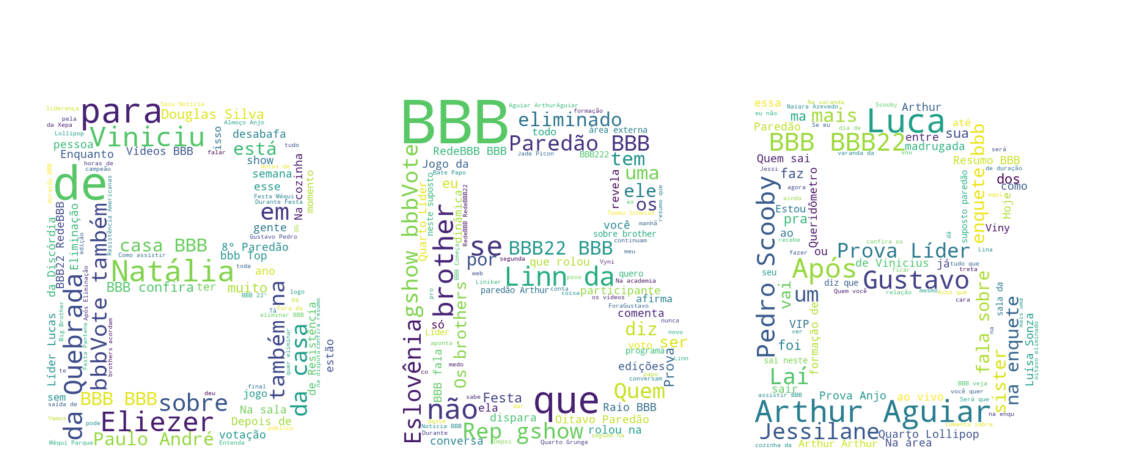

In [ ]:
#Palavras mais usadas em nuvem de palalvras
words = ' '.join(tweets_df_pt['Texto'])

words_clean = " ".join([word for word in words.split()])

warnings.simplefilter('ignore')

mask = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Projetos/BBB/BBB.png'))
wc = WordCloud(stopwords=STOPWORDS, mask=mask,
               max_words=1000, max_font_size=100,
               min_font_size=10, random_state=42,
               background_color='white', mode="RGB",
               width=mask.shape[1], height=mask.shape[0],
               normalize_plurals=True).generate(words_clean)

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('bbb_word.png', dpi=600)
plt.show()

#### Origem dos tweets

In [ ]:
#mapa das origens dos tweets
geolocator = Nominatim(user_agent="TweeterSentiments")

latitude = []
longitude = []

for user_location in tweets_df_pt['Localização']:
  try:
    location = geolocator.geocode(user_location)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
  except:
    continue

coordenadas = np.column_stack((latitude, longitude))

mapa = folium.Map(zoom_start=3.)
mapa.add_child(plugins.HeatMap(coordenadas))
mapa.save('Mapa_calor_tweets.html')
#mapa

In [ ]:
mapa

Nota-se maior correspondência de tweets enviados da região Sudeste e Nordeste, também algumas capitais em alguns estados. Existe um grande número de tweets com endereços fictícios ou com valores nulos (neste último caso não é um problema para a plotagem)

#### Tweets ao longo do tempo

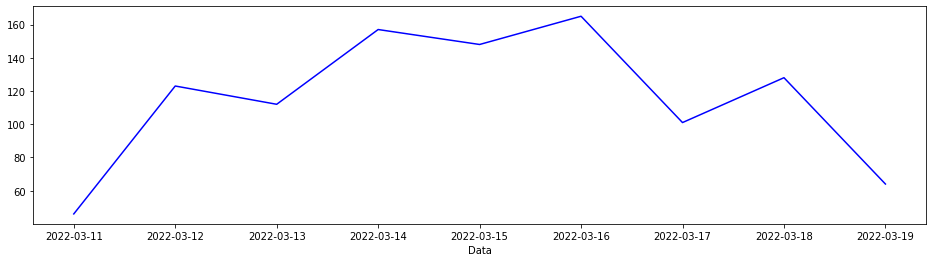

In [ ]:
#Análise temporal
data = tweets_df_pt
data['Data'] = pd.to_datetime(data['Data']).apply(lambda x: x.date())
tlen = pd.Series(data['Data'].value_counts(), index=data['Data'])
tlen.plot(figsize=(16,4), color='b')
#plt.grid(False)
plt.savefig('timeline_tweets.png', bbox_inches='tight', pad_inches=0.5)

Ainda é necessário confirmação (devido a limitação de tweets), mas existe uma tendência de volume de tweets maior nas segundas,terças e quarta-feiras

---

In [ ]:
#Baixar as figuras/arquivos gerados
files.download('Mapa_calor_tweets.html')
files.download("bbb_word.png") 
files.download("sentimentos_tweets.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('timeline_tweets.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Snippets de códigos

In [ ]:
#para localizar e clicar no botão 'veja mais'
#from selenium.webdriver.common.by import By
# button = wd.find_element_by_css_selector('.load-more > a:nth-child(1)')
# print(button.get_attribute('href'))

#print(new_height)


In [ ]:
#SaveFig

#plt.savefig("abc.png")
#files.download("bbb_word.png") 

In [ ]:
# class tweepy.API(auth=None, *, cache=None, 
#                  host='api.twitter.com', parser=None, 
#                  proxy=None, retry_count=0, retry_delay=0, 
#                  retry_errors=None, timeout=60, upload_host='upload.twitter.com', 
#                  user_agent=None, wait_on_rate_limit=False)